# Importing Libaries

In [5576]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 
from datetime import timedelta

# Libraries for model building
from scipy.stats.mstats     import winsorize
from sklearn.linear_model   import LogisticRegression 
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.svm            import SVC
from sklearn.tree           import DecisionTreeClassifier
from sklearn.metrics        import auc
from sklearn.metrics        import roc_auc_score

# Importing data

In [5577]:
# Importing data

camp = pd.read_csv('../data/raw/campaigns.csv', sep=';')
donors = pd.read_csv('../data/raw/donors.csv', sep=',')
gifts = pd.read_csv('../data/raw/gifts.csv', sep=',')
sc6 = pd.read_csv('../data/raw/selection campaign 6169.csv')
sc7 = pd.read_csv('../data/raw/selection campaign 7244.csv')

In [5578]:
# Basic exploration 
print("Donors shape:", donors.shape) 
print("Gifts shape:", gifts.shape) 
print("Campaign 6169 shape:", sc6.shape) 
print("Campaign 7244 shape:", sc7.shape)

Donors shape: (44691, 7)
Gifts shape: (216594, 4)
Campaign 6169 shape: (34888, 1)
Campaign 7244 shape: (25645, 1)


# References

In [5579]:
rd1 = pd.to_datetime('2018-09-04') # date of 6169 campaign
rd2 = pd.to_datetime('2019-06-18') # date of 7244 campaign

# I/ Data description + Cleaning

## 1) Campaign

### General inspection

In [5580]:
# Displaying the campaign table
camp.head()

,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [5581]:
# Displaying information
camp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   campaignID   367 non-null    int64 
 1   date         367 non-null    object
 2   lettersSent  367 non-null    object
 3   CostUnit     367 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.6+ KB


### Missing values and outliers

In [5582]:
# Convert date to datetime
camp['date'] = pd.to_datetime(camp['date'])

C:\Users\Source\AppData\Local\Temp\ipykernel_38800\4099330542.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  camp['date'] = pd.to_datetime(camp['date'])


In [5583]:
camp.head()

,campaignID,date,lettersSent,CostUnit
0,153,2004-12-13,6 873,"0,17 €"
1,154,2005-01-01,7 656,"0,30 €"
2,180,2005-01-18,9 933,"0,20 €"
3,433,2005-01-29,7 448,"0,59 €"
4,476,2005-02-12,6 605,"0,51 €"


In [5584]:
# Convert the letterSent and cost per unit to a number
# To find outliers, we need to convert columns to integer before
# We use a raw string character that will find all types of whitespaces not just blanks
camp['lettersSent'] = (
    camp['lettersSent']
        .astype(str)
        .str.replace(r'\D+', '', regex=True)
        .astype(int)
)

camp['CostUnit'] = (
    camp['CostUnit']
        .astype(str)
        .str.replace(r'[^0-9,.-]', '', regex=True)
        .str.replace(',', '.', regex=False)
        .astype(float)
)
camp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   campaignID   367 non-null    int64         
 1   date         367 non-null    datetime64[ns]
 2   lettersSent  367 non-null    int64         
 3   CostUnit     367 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 11.6 KB


In [5585]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(camp.isna().sum())
print('---------------------------------')
print(f'The data shows {camp.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
campaignID     0
date           0
lettersSent    0
CostUnit       0
dtype: int64
---------------------------------
The data shows 0 missing values


In [5586]:
# Finding outliers (using only the numerical columns)
num_cols = camp.select_dtypes(include=['float', 'int']).columns.drop('campaignID')
# We define our boundaries
lower = camp[num_cols].quantile(0.01)
upper = camp[num_cols].quantile(0.99)

# printing the results
print('Lower bounds:\n',lower)
print('-------------------------')
print('Upper bounds:\n', upper)

Lower bounds:
 lettersSent    5243.66
CostUnit          0.02
Name: 0.01, dtype: float64
-------------------------
Upper bounds:
 lettersSent    47746.96
CostUnit           0.61
Name: 0.99, dtype: float64


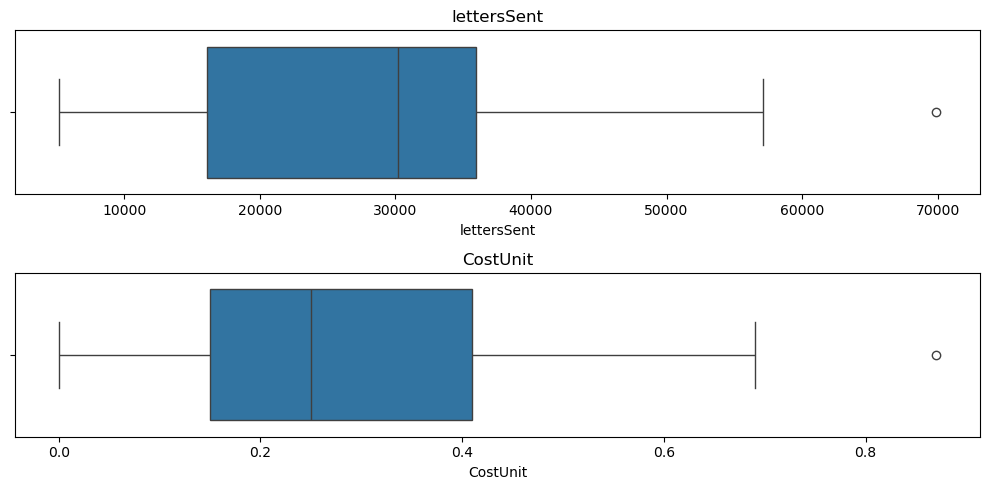

In [5587]:
# Verifying outliers
# We use boxplots to identify potential outliers

fig, ax = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(10, 5))

for i, col in enumerate(num_cols):
    sns.boxplot(ax=ax[i], x=camp[col])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [5588]:
# Replace lower and upper values by the value of bottom 1% and top 99% (winsorization)
camp = camp.copy()
camp[num_cols] = camp[num_cols].clip(lower=lower, upper=upper, axis=1)

In [5589]:
# Verifying winsorization worked
for col in num_cols:
    print(col, 'min :', round(camp[col].min(),2))
    print(col, 'max :', round(camp[col].max(),2))

lettersSent min : 5243.66
lettersSent max : 47746.96
CostUnit min : 0.02
CostUnit max : 0.61


In [5590]:
camp.head(2)

,campaignID,date,lettersSent,CostUnit
0,153,2004-12-13,6873.0,0.17
1,154,2005-01-01,7656.0,0.30


## 2) Donors

### General inspection

In [5591]:
# Displaying the donors table
donors.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967
1,D100002,2260.0,Antwerp,Flanders,M,NL,01/14/1952
2,D100003,1780.0,Flemish Brabant,Flanders,M,NL,12/23/1986
3,D100004,1020.0,Brussels,Brussels,F,FR,03/29/1952
4,D100005,1020.0,Brussels,Brussels,F,FR,06/25/1986


In [5592]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   donorID      44691 non-null  object 
 1   zipcode      44689 non-null  float64
 2   province     44691 non-null  object 
 3   region       44691 non-null  object 
 4   gender       44659 non-null  object 
 5   language     44691 non-null  object 
 6   dateOfBirth  44691 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.4+ MB


### Missing values and outliers

In [5593]:
# Convert date to datetime
donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'])

In [5594]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(donors.isna().sum())
print('---------------------------------')
print(f'The data shows {donors.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID         0
zipcode         2
province        0
region          0
gender         32
language        0
dateOfBirth     0
dtype: int64
---------------------------------
The data shows 34 missing values


In [5595]:
# Handling missing values

# zipcode
donors = donors.dropna(subset=['zipcode']) # since it represents only two observation and there is no other logical way to inpute them

# gender
gender_mode = donors['gender'].mode()[0]
donors['gender'] = donors['gender'].fillna(value=gender_mode) #filling by the mode seems relevant for this amount of data (32 out of 44 689 clients)

print(f'The data shows {donors.isna().sum().sum()} missing values now')

The data shows 0 missing values now


In [5596]:
# Checking that there are indeed 44 689 different clients
donors.shape

(44689, 7)

In [5597]:
donors.zipcode

0        1861.0
1        2260.0
2        1780.0
3        1020.0
4        1020.0
          ...  
44686    4900.0
44687    3600.0
44688    3061.0
44689    1950.0
44690    1160.0
Name: zipcode, Length: 44689, dtype: float64

In [5598]:
# Zipcode was imported as float (e.g., 1180.0), but zipcodes are categorical labels
# We convert to integer to remove decimals, then to string so models don't treat it as numeric (which can mislead models)
donors['zipcode'] = donors['zipcode'].astype('Int64').astype(str)

In [5599]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   donorID      44689 non-null  object        
 1   zipcode      44689 non-null  object        
 2   province     44689 non-null  object        
 3   region       44689 non-null  object        
 4   gender       44689 non-null  object        
 5   language     44689 non-null  object        
 6   dateOfBirth  44689 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 2.7+ MB


In [5600]:
donors.head(2)

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14


## 3) Gifts

### General inspection

In [5601]:
# Displaying the gifts table
gifts.head()

,donorID,campaignID,amount,date
0,D100001,NaN,"12,39",23/03/2004
1,D100001,1577.0,"12,39",11/10/2007
2,D100001,1634.0,"6,69",28/12/2007
3,D100001,1778.0,"24,79",14/06/2008
4,D100001,1808.0,"7,44",09/07/2008


In [5602]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   donorID     216594 non-null  object 
 1   campaignID  200957 non-null  float64
 2   amount      216594 non-null  object 
 3   date        216594 non-null  object 
dtypes: float64(1), object(3)
memory usage: 6.6+ MB


### Missing values and outliers

In [5603]:
# Convert date to datetime
gifts['date'] = pd.to_datetime(gifts['date'])

# Be more specific
gifts = gifts.rename(columns={'date' : 'gift_date'})

C:\Users\Source\AppData\Local\Temp\ipykernel_38800\2177558126.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  gifts['date'] = pd.to_datetime(gifts['date'])


In [5604]:
# Convert amount to numeric
gifts['amount'] = (
    gifts['amount']
    .astype(str)
    .str.replace(".", "", regex=False)   # remove thousand separators
    .str.replace(",", ".", regex=False)  # convert decimal comma → dot
)
gifts['amount'] = pd.to_numeric(gifts['amount'], errors='coerce')



In [5605]:
gifts.head()

,donorID,campaignID,amount,gift_date
0,D100001,NaN,12.39,2004-03-23
1,D100001,1577.0,12.39,2007-10-11
2,D100001,1634.0,6.69,2007-12-28
3,D100001,1778.0,24.79,2008-06-14
4,D100001,1808.0,7.44,2008-07-09


In [5606]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(gifts.isna().sum())
print('---------------------------------')
print(f'The data shows {gifts.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID           0
campaignID    15637
amount           23
gift_date         0
dtype: int64
---------------------------------
The data shows 15660 missing values


In [5607]:
gifts.campaignID = gifts.campaignID.fillna(value=0)
print(f'The data shows {gifts.isna().sum().sum()} missing values')

The data shows 23 missing values


Handling the missing ID's : 
- A missing ID means that a donation was NOT part of any campaign - it was a spontaneous donation
- This gives a valuable information and could be very useful for our models 
- Thus, we should keep them as they are 

In [5608]:
gifts.head(3)

,donorID,campaignID,amount,gift_date
0,D100001,0.0,12.39,2004-03-23
1,D100001,1577.0,12.39,2007-10-11
2,D100001,1634.0,6.69,2007-12-28


In [5609]:
gifts.sort_values(by = 'amount', ascending=False)

,donorID,campaignID,amount,gift_date
153012,D123168,0.0,4000000.00,2010-04-26
141895,D120861,1917.0,2479000.00,2008-11-17
150654,D122679,2417.0,30000.00,2010-07-04
182959,D130966,1377.0,12394.68,2007-04-21
21410,D102552,3785.0,5000.00,2014-05-03
...,...,...,...,...
139335,D120368,0.0,NaN,2006-10-18
139336,D120368,0.0,NaN,2006-12-03
172552,D128000,7005.0,NaN,2019-01-07
197762,D135598,3249.0,NaN,2012-07-26


In [5610]:
amount_median = gifts.amount.median()

gifts.amount = gifts.amount.fillna(amount_median)
gifts['outside_campaign'] = 0
gifts.loc[gifts['campaignID'] == 0,'outside_campaign'] = 1

gifts.isna().sum()

donorID             0
campaignID          0
amount              0
gift_date           0
outside_campaign    0
dtype: int64

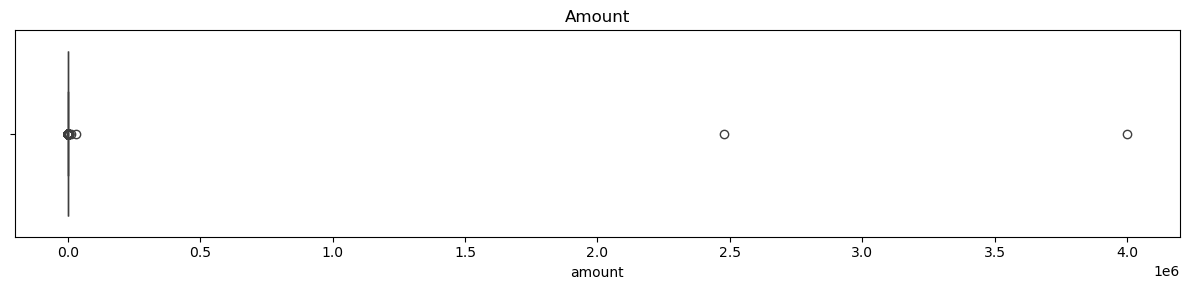

In [5611]:
# Verifying outliers

fig, ax = plt.subplots(figsize=(12, 3))

sns.boxplot(x=gifts['amount'])
ax.set_title('Amount')

plt.tight_layout()
plt.show()

In [5612]:
# Winsorizing the results
lower = gifts['amount'].quantile(0.01)
upper = gifts['amount'].quantile(0.99)

# printing the results
print(lower)
print(upper)

2.48
123.95


In [5613]:
# Replace lower and upper values by the value of bottom 1% and top 99% (winsorization)
gifts = gifts.copy()
gifts['amount'] = gifts['amount'].clip(lower=lower, upper=upper*3)

In [5614]:
gifts['amount'].max()

371.85

In [5615]:
gifts.head(2)

,donorID,campaignID,amount,gift_date,outside_campaign
0,D100001,0.0,12.39,2004-03-23,1
1,D100001,1577.0,12.39,2007-10-11,0


In [5616]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   donorID           216594 non-null  object        
 1   campaignID        216594 non-null  float64       
 2   amount            216594 non-null  float64       
 3   gift_date         216594 non-null  datetime64[ns]
 4   outside_campaign  216594 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 8.3+ MB


## 4) Selection campaign 6169

### General inspection

In [5617]:
# Displaying the sc6 table
sc6.head()

,donorID
0,D100001
1,D100002
2,D100004
3,D100008
4,D100009


### Missing values

In [5618]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(sc6.isna().sum())
print('---------------------------------')
print(f'The data shows {sc6.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID    0
dtype: int64
---------------------------------
The data shows 0 missing values


## 5) selection campaign 7244

### General inspection

In [5619]:
# Displaying the sc7 table
sc7.head()

,donorID
0,D100001
1,D100002
2,D100008
3,D100009
4,D100010


### Missing values

In [5620]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(sc7.isna().sum())
print('---------------------------------')
print(f'The data shows {sc7.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID    0
dtype: int64
---------------------------------
The data shows 0 missing values


# II/ Dependent variables (train + validation set)

## 1) Train set

In [5621]:
# Setting up the campaign date
campaign_date_6169 = rd1
campaign_date_6169

Timestamp('2018-09-04 00:00:00')

We need to define our gap period. A gap period is crucial as it allows the model to train, to send the campaign and avoid data leakage.
A one month Gap period is geenrally considered a standard in the industry

In [5622]:
# Gap period: 1 week after campaign
gap_days = 7

In [5623]:
# End of the gap period 
gap_end = campaign_date_6169 + timedelta(days = gap_days)
gap_end

Timestamp('2018-09-11 00:00:00')

In [5624]:
#feature_cutoff_6169 = campaign_date_6169 - timedelta(gap_days)
#feature_cutoff_6169

We define our response window. This is the period where we will check if someone donated after the campaign. We will use a window of 60 days in order to gather meaningful results quickly

In [5625]:
response_window = 60

In [5626]:
post_campaign_train = gifts[(gifts['gift_date'] > gap_end) & (gifts['gift_date'] <= gap_end+timedelta(response_window))]

# We verify that the window is respected
print(post_campaign_train.gift_date.min())
print(post_campaign_train.gift_date.max())

2018-09-12 00:00:00
2018-11-08 00:00:00


In [5627]:
post_campaign_train.head(3)

,donorID,campaignID,amount,gift_date,outside_campaign
19,D100003,6922.0,4.0,2018-10-23,0
132,D100023,6169.0,15.0,2018-09-15,0
284,D100034,6170.0,45.0,2018-09-19,0


In [5628]:
responses_train = post_campaign_train.groupby('donorID')['amount'].sum().reset_index()

responses_train.head(3)

,donorID,amount
0,D100003,4.0
1,D100023,15.0
2,D100034,45.0


In [5629]:
sc6.head(2)

,donorID
0,D100001
1,D100002


In [5630]:
sc6.shape

(34888, 1)

In [5631]:
# Merging gifts and sc6 as gifts contains the donation history and we want to select those who were selected in the campaign

train_targets = sc6.merge(responses_train, on='donorID', how='left')
train_targets['amount'] = train_targets['amount'].fillna(0)
train_targets['target'] = (train_targets['amount'] >= 30).astype(int) # cast the values as binary, with >=30 = 1, else 0
train_targets = train_targets.drop(columns = 'amount')

train_targets.head()

,donorID,target
0,D100001,0
1,D100002,0
2,D100004,0
3,D100008,0
4,D100009,0


In [5632]:
train_targets['target'].value_counts()

target
0    34123
1      765
Name: count, dtype: int64

In [5633]:
train_targets.shape

(34888, 2)

## 2) Validation set

We follow the exact same steps and logic as we did before

In [5634]:
campaign_date_7244 = rd2
campaign_date_7244

Timestamp('2019-06-18 00:00:00')

In [5635]:
# End of the gap period 
gap_end = campaign_date_7244 + timedelta(days = gap_days)
gap_end

Timestamp('2019-06-25 00:00:00')

In [5636]:
 # we use the same gap days as in the train table
#feature_cutoff_7244 = campaign_date_7244 - timedelta(gap_days)
#feature_cutoff_7244

In [5637]:
# We also use the same response window as in the train table 
post_campaign_validation = gifts[(gifts['gift_date'] > gap_end) & (gifts['gift_date'] <= gap_end+timedelta(response_window))]

print(post_campaign_validation.gift_date.min())
print(post_campaign_validation.gift_date.max())

2019-06-26 00:00:00
2019-08-24 00:00:00


In [5638]:
post_campaign_validation.head(3)

,donorID,campaignID,amount,gift_date,outside_campaign
4042,D100548,0.0,50.0,2019-08-03,1
4780,D100607,0.0,4.0,2019-06-27,1
4781,D100607,0.0,4.0,2019-07-27,1


In [5639]:
responses_validation = post_campaign_validation.groupby('donorID')['amount'].sum().reset_index()

responses_validation.head(3)

,donorID,amount
0,D100548,50.0
1,D100607,8.0
2,D100724,40.0


In [5640]:
sc7.shape

(25645, 1)

In [5641]:
# Merging gifts and sc6 as gifts contains the donation history and we want to select those who were selected in the campaign

validation_targets = sc7.merge(responses_validation, on='donorID', how='left')
validation_targets['amount'] = validation_targets['amount'].fillna(0)
validation_targets['target'] = (validation_targets['amount'] >= 30).astype(int) # cast the values as binary, with >=30 = 1, else 0
validation_targets = validation_targets.drop(columns = 'amount')

validation_targets.head()

,donorID,target
0,D100001,0
1,D100002,0
2,D100008,0
3,D100009,0
4,D100010,0


In [5642]:
validation_targets['target'].value_counts()

target
0    25464
1      181
Name: count, dtype: int64

In [5643]:
validation_targets.shape

(25645, 2)

# III/ Independent variable & basetable creation

## Training set

In [5644]:
train_features = sc6.copy()

In [5645]:
# Merge with donors table
train_features = train_features.merge(donors, on='donorID', how='left')

train_features.head(3)

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14
2,D100004,1020,Brussels,Brussels,F,FR,1952-03-29


### Demographics

#### Age

In [5646]:
# Calculate age at FEATURE CUTOFF date (Aug 5, 2018)
train_features["age"] = ( (campaign_date_6169.year - train_features["dateOfBirth"].dt.year))

# Fill missing ages with the median
train_features["age"] = train_features["age"].fillna(train_features["age"].median()).astype(int)

train_features.head(5)

,donorID,zipcode,province,region,gender,language,dateOfBirth,age
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,51
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14,66
2,D100004,1020,Brussels,Brussels,F,FR,1952-03-29,66
3,D100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30,81
4,D100009,1020,Brussels,Brussels,M,FR,1932-01-20,86


#### age_group

In [5647]:
# Computing the age group

train_features['age_group'] = train_features['age'].apply(lambda x : 'youth' if x<=25 
                                                          else('adult' if x>25 and x<40 
                                                               else('middle_aged' if x>=40 and x<65 
                                                                    else'senior')))

train_features.head(3)

,donorID,zipcode,province,region,gender,language,dateOfBirth,age,age_group
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,51,middle_aged
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14,66,senior
2,D100004,1020,Brussels,Brussels,F,FR,1952-03-29,66,senior


#### Dealing with categorical varaibles

We have many categorical variables (objects) that need to be one hot encoded as per models requirements

In [5648]:
# Selecting only the categorical variables 
obj_cols = train_features.select_dtypes(include='object').drop(columns='donorID').columns # exlude the donorID as it is not a feature
obj_cols

Index(['zipcode', 'province', 'region', 'gender', 'language', 'age_group'], dtype='object')

In [5649]:
for col in obj_cols:
    print('Number of unique values in', col, ':', train_features[col].nunique())

Number of unique values in zipcode : 963
Number of unique values in province : 12
Number of unique values in region : 3
Number of unique values in gender : 2
Number of unique values in language : 3
Number of unique values in age_group : 4


In [5650]:
# We first drop the zipcode varaiblea as it does not add any additional values given that we already have province and region
# One hot encoding is also impossible given the high number of unique values, this will pollute our models (eg. multicolinearity)

obj_cols = obj_cols.drop('zipcode')

train_features = train_features.drop(columns='zipcode')

'zipcode' in train_features

False

In [5651]:
#As we can see in unique values there are 3 categories in region and language but (Nulls are included) but 
#When doing one-hot encoding we loose these null values (Only 2 categories in region and language), we are removing null values.
#I'm label them as 'missing' so we get 3 categories in in region and language
#sebastian

train_features[['province', 'region', 'language', 'age_group']] = train_features[['province',
                                                                                   'region',
                                                                                    'language',
                                                                                    'age_group']].fillna(value= 'missing')


In [5652]:
# 1. One-hot encode categorical variables
train_features = pd.get_dummies(
    train_features,
    columns=obj_cols,   # your list of categorical columns
    drop_first=True
)

# 2. Convert only the dummy columns (boolean → int)
bool_cols = train_features.select_dtypes(include="bool").columns
train_features[bool_cols] = train_features[bool_cols].astype(int)

train_features.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,region_Flanders,region_Wallonia,region_missing,gender_M,language_FR,language_NL,language_missing,age_group_middle_aged,age_group_senior,age_group_youth
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,1,0
2,D100004,1952-03-29,66,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,D100008,1937-08-30,81,0,0,0,1,0,0,0,...,1,0,0,1,1,0,0,0,1,0
4,D100009,1932-01-20,86,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0


In [5653]:
train_features.shape

(34888, 25)

### Timing (RFM + LOR)

We first define our lookback days : our independent variables time window
- In theory we can take everything before the cutoff date that we defined earlier 
- However, we need to ensure that the train, validation and test tables have the same time window lenght
- Thus we need to define a lookback period that will be identical for all of them 

In [5654]:
# We define our lookback days
lookback_days = 1825   # Coresponds to 5 years

# We define the start of our window given the lookback days
window_start_6169 = campaign_date_6169 - timedelta(lookback_days)

In [5655]:
# Use only gifts BEFORE the feature cutoff (gap respected)
gifts_before_6169 = gifts[
    (gifts["gift_date"] >= window_start_6169) &
    (gifts["gift_date"] < campaign_date_6169) # TO VERIFY !!!! change ingap ?
].copy()

gifts_before_6169.head(3)

,donorID,campaignID,amount,gift_date,outside_campaign
12,D100002,3941.0,20.0,2015-01-10,0
13,D100003,4801.0,5.0,2017-07-27,0
14,D100003,4830.0,3.0,2017-08-11,0


In [5656]:
# We group by donor and compute donation history metrics
rfm_6169 = gifts_before_6169.groupby("donorID").agg(
    first_gift=("gift_date", "min"),
    last_gift=("gift_date", "max"),
    frequency=("amount", "count"),
    total_amount=("amount", "sum"),
    avg_amount=("amount", "mean"),
    max_amount=("amount", "max"),
    min_amount=("amount", "min")
)

#Total donated outside campaign
rfm_6169['donated_outs_camp'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['outside_campaign'] == 1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].sum()
rfm_6169['num_outs_camp'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['outside_campaign'] == 1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].count()

#Total donated inside campaign
rfm_6169['donated_ins_camp'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['outside_campaign'] == 0) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].sum()
rfm_6169['num_ins_camp'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['outside_campaign'] == 0) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].count()

#Total donated last year
rfm_6169['donated_last_year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2017-09-04')].groupby('donorID')['amount'].sum()
rfm_6169['count_last_year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2017-09-04')].groupby('donorID')['amount'].count()
rfm_6169['last_year_mean'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2017-09-04')].groupby('donorID')['amount'].mean()

#Total donated last 3 years
rfm_6169['donated_last_3year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2015-09-04')].groupby('donorID')['amount'].sum()
rfm_6169['count_last_3year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2015-09-04')].groupby('donorID')['amount'].count()
rfm_6169['last_3year_mean'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2015-09-04')].groupby('donorID')['amount'].mean()

#Total donated last month
rfm_6169['donated_last_month'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-08-04')].groupby('donorID')['amount'].sum()
rfm_6169['count_last_month'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-08-04')].groupby('donorID')['amount'].count()
rfm_6169['last_month_mean'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-08-04')].groupby('donorID')['amount'].mean()

#Total donated last 3months
rfm_6169['donated_last_3months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-06-04')].groupby('donorID')['amount'].sum()
rfm_6169['count_last_3months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-06-04')].groupby('donorID')['amount'].count()
rfm_6169['last_month_3means'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-06-04')].groupby('donorID')['amount'].mean()

#Total donated last 6months
rfm_6169['donated_last_6months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-03-04')].groupby('donorID')['amount'].sum()
rfm_6169['count_last_6months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-03-04')].groupby('donorID')['amount'].count()
rfm_6169['last_month_6means'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-03-04')].groupby('donorID')['amount'].mean()

#Total donated last 9months
rfm_6169['donated_last_9months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2017-12-04')].groupby('donorID')['amount'].sum()
rfm_6169['count_last_9months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2017-12-04')].groupby('donorID')['amount'].count()
rfm_6169['last_month_9means'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2017-12-04')].groupby('donorID')['amount'].mean()

#Ratios
rfm_6169['ratio_amount'] = (gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].sum() /
                            gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')]['amount'].sum())

rfm_6169['ratio_count_amount'] = (gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].count() /
                                gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')]['amount'].count())


rfm_6169.head()

,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount,donated_outs_camp,num_outs_camp,donated_ins_camp,...,count_last_3months,last_month_3means,donated_last_6months,count_last_6months,last_month_6means,donated_last_9months,count_last_9months,last_month_9means,ratio_amount,ratio_count_amount
donorID,,,,,,,,,,,,,,,,,,,,,
D100002,2015-01-10,2015-01-10,1,20.0,20.000000,20.0,20.0,NaN,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000017,0.000024
D100003,2017-07-27,2018-07-08,5,18.0,3.600000,5.0,3.0,NaN,NaN,22.0,...,3.0,3.666667,11.0,3.0,3.666667,11.0,3.0,3.666667,0.000019,0.000143
D100005,2016-10-26,2018-06-19,2,10.0,5.000000,5.0,5.0,NaN,NaN,10.0,...,1.0,5.000000,5.0,1.0,5.000000,5.0,1.0,5.000000,0.000009,0.000048
D100006,2017-08-15,2017-08-15,1,5.0,5.000000,5.0,5.0,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000004,0.000024
D100007,2014-05-13,2017-11-30,3,100.0,33.333333,40.0,30.0,NaN,NaN,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000087,0.000072


In [5657]:
# We compute RECENCY and TENURE
rfm_6169["recency_days"] = (campaign_date_6169 - rfm_6169["last_gift"]).dt.days

rfm_6169.head(3)

,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount,donated_outs_camp,num_outs_camp,donated_ins_camp,...,last_month_3means,donated_last_6months,count_last_6months,last_month_6means,donated_last_9months,count_last_9months,last_month_9means,ratio_amount,ratio_count_amount,recency_days
donorID,,,,,,,,,,,,,,,,,,,,,
D100002,2015-01-10,2015-01-10,1,20.0,20.0,20.0,20.0,NaN,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000017,0.000024,1333
D100003,2017-07-27,2018-07-08,5,18.0,3.6,5.0,3.0,NaN,NaN,22.0,...,3.666667,11.0,3.0,3.666667,11.0,3.0,3.666667,0.000019,0.000143,58
D100005,2016-10-26,2018-06-19,2,10.0,5.0,5.0,5.0,NaN,NaN,10.0,...,5.000000,5.0,1.0,5.000000,5.0,1.0,5.000000,0.000009,0.000048,77


In [5658]:
# Length Of Relationship (LOR)
rfm_6169["LOR"] = (rfm_6169["last_gift"] - rfm_6169["first_gift"]).dt.days

rfm_6169.head(3)

,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount,donated_outs_camp,num_outs_camp,donated_ins_camp,...,donated_last_6months,count_last_6months,last_month_6means,donated_last_9months,count_last_9months,last_month_9means,ratio_amount,ratio_count_amount,recency_days,LOR
donorID,,,,,,,,,,,,,,,,,,,,,
D100002,2015-01-10,2015-01-10,1,20.0,20.0,20.0,20.0,NaN,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000017,0.000024,1333,0
D100003,2017-07-27,2018-07-08,5,18.0,3.6,5.0,3.0,NaN,NaN,22.0,...,11.0,3.0,3.666667,11.0,3.0,3.666667,0.000019,0.000143,58,346
D100005,2016-10-26,2018-06-19,2,10.0,5.0,5.0,5.0,NaN,NaN,10.0,...,5.0,1.0,5.000000,5.0,1.0,5.000000,0.000009,0.000048,77,601


In [5659]:
# Drop date columns (we already extracted useful info)
rfm_6169 = rfm_6169.drop(columns=["first_gift", "last_gift"])

In [5660]:
# Merge into your existing feature table
train_features = train_features.merge(rfm_6169, on="donorID", how="left")

train_features.head(3)

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,donated_last_6months,count_last_6months,last_month_6means,donated_last_9months,count_last_9months,last_month_9means,ratio_amount,ratio_count_amount,recency_days,LOR
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000017,0.000024,1333.0,0.0
2,D100004,1952-03-29,66,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5661]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   donorID                   34888 non-null  object        
 1   dateOfBirth               34872 non-null  datetime64[ns]
 2   age                       34888 non-null  int64         
 3   province_Antwerp          34888 non-null  int64         
 4   province_Brussels         34888 non-null  int64         
 5   province_East Flanders    34888 non-null  int64         
 6   province_Flemish Brabant  34888 non-null  int64         
 7   province_Hainaut          34888 non-null  int64         
 8   province_Liege            34888 non-null  int64         
 9   province_Limburg          34888 non-null  int64         
 10  province_Luxembourg       34888 non-null  int64         
 11  province_Namur            34888 non-null  int64         
 12  province_Walloon B

### Campaign-specific

We need this to get 'CostUnit' associated with each gift, therefore, we will temporarily merge gifts and campaign data to get it. Indeed, gift is the only table that can link our basetable with campaign, since it has the campaignID key

In [5662]:
print(gifts['campaignID'].dtype)
print(camp['campaignID'].dtype)


float64
int64


In [5663]:
camp['campaignID'] = camp['campaignID'].astype(float)
gifts['campaignID'] = gifts['campaignID'].astype(float)

In [5664]:
# Merge gifts with campaign metadata
gifts_with_costs = pd.merge(gifts, camp, on='campaignID', how='left')
gifts_with_costs.head(3)

,donorID,campaignID,amount,gift_date,outside_campaign,date,lettersSent,CostUnit
0,D100001,0.0,12.39,2004-03-23,1,NaT,NaN,NaN
1,D100001,1577.0,12.39,2007-10-11,0,2007-10-09,34636.0,0.31
2,D100001,1634.0,6.69,2007-12-28,0,2007-12-08,34080.0,0.21


In [5665]:
# Restrict to the SAME lookback window as RFM
history_campaigns_6169 = gifts_with_costs[
    (gifts_with_costs["gift_date"] >= window_start_6169) &
    (gifts_with_costs["gift_date"] < campaign_date_6169)
].copy()

history_campaigns_6169.head(3)

,donorID,campaignID,amount,gift_date,outside_campaign,date,lettersSent,CostUnit
12,D100002,3941.0,20.0,2015-01-10,0,2014-12-25,37833.00,0.50
13,D100003,4801.0,5.0,2017-07-27,0,2017-07-13,47746.96,0.21
14,D100003,4830.0,3.0,2017-08-11,0,2017-08-09,28955.00,0.19


In [5666]:
# How expensive are the campaigns they support? (get an idea of their relative importance)
 # What is the importance of the campaign they support
campaign_features_6169 = history_campaigns_6169.groupby("donorID").agg(
    CostUnit_mean   = ("CostUnit", "mean"),
    CostUnit_min    = ("CostUnit", "min"),
    CostUnit_max    = ("CostUnit", "max"),
    lettersSent_mean= ("lettersSent", "mean")
).reset_index()

campaign_features_6169.head(3)

,donorID,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean
0,D100002,0.500,0.50,0.5,37833.000
1,D100003,0.196,0.07,0.3,35984.792
2,D100005,0.275,0.25,0.3,33251.000


In [5667]:
# Cost range = variability in campaign cost
campaign_features_6169["CostUnit_range"] = (
    campaign_features_6169["CostUnit_max"] - campaign_features_6169["CostUnit_min"]
)

campaign_features_6169.head(3)

,donorID,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range
0,D100002,0.500,0.50,0.5,37833.000,0.00
1,D100003,0.196,0.07,0.3,35984.792,0.23
2,D100005,0.275,0.25,0.3,33251.000,0.05


In [5668]:
# Merging everything in one basetable

basetable_train = train_features.merge(campaign_features_6169, on="donorID", how="left")

basetable_train.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,last_month_9means,ratio_amount,ratio_count_amount,recency_days,LOR,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,NaN,0.000017,0.000024,1333.0,0.0,0.5,0.5,0.5,37833.0,0.0
2,D100004,1952-03-29,66,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D100008,1937-08-30,81,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D100009,1932-01-20,86,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5669]:
basetable_train.columns

Index(['donorID', 'dateOfBirth', 'age', 'province_Antwerp',
       'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders',
       'province_missing', 'region_Flanders', 'region_Wallonia',
       'region_missing', 'gender_M', 'language_FR', 'language_NL',
       'language_missing', 'age_group_middle_aged', 'age_group_senior',
       'age_group_youth', 'frequency', 'total_amount', 'avg_amount',
       'max_amount', 'min_amount', 'donated_outs_camp', 'num_outs_camp',
       'donated_ins_camp', 'num_ins_camp', 'donated_last_year',
       'count_last_year', 'last_year_mean', 'donated_last_3year',
       'count_last_3year', 'last_3year_mean', 'donated_last_month',
       'count_last_month', 'last_month_mean', 'donated_last_3months',
       'count_last_3months', 'last_month_3means', 'donated_last_6month

In [5670]:
# Adding some features

# 1) Average donation per letter received
basetable_train["amount_per_letter"] = (basetable_train["total_amount"] / (basetable_train["lettersSent_mean"] + 1))

# 2) Gifts per year relative to length of relationship in the window
basetable_train["gifts_per_year"] = (basetable_train["frequency"] / (basetable_train["LOR"] / 365 + 1))

# 3) Ratio of most recent max value vs average donation
basetable_train["current_value_ratio"] = (basetable_train["max_amount"] / (basetable_train["avg_amount"] + 1))

In [5671]:
basetable_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 64 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   donorID                   34888 non-null  object        
 1   dateOfBirth               34872 non-null  datetime64[ns]
 2   age                       34888 non-null  int64         
 3   province_Antwerp          34888 non-null  int64         
 4   province_Brussels         34888 non-null  int64         
 5   province_East Flanders    34888 non-null  int64         
 6   province_Flemish Brabant  34888 non-null  int64         
 7   province_Hainaut          34888 non-null  int64         
 8   province_Liege            34888 non-null  int64         
 9   province_Limburg          34888 non-null  int64         
 10  province_Luxembourg       34888 non-null  int64         
 11  province_Namur            34888 non-null  int64         
 12  province_Walloon B

In [5672]:
#basetable_train = basetable_train.drop(columns="dateOfBirth")   to drop later

In [5673]:
basetable_train.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,recency_days,LOR,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range,amount_per_letter,gifts_per_year,current_value_ratio
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,1333.0,0.0,0.5,0.5,0.5,37833.0,0.0,0.000529,1.0,0.952381
2,D100004,1952-03-29,66,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D100008,1937-08-30,81,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D100009,1932-01-20,86,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5674]:
basetable_train.shape

(34888, 64)

## 2) Validation set

In [5675]:
val_features = sc7.copy()

In [5676]:
# Merge with donors table
val_features = val_features.merge(donors, on='donorID', how='left')

val_features.head(3)

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14
2,D100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30


### a) demographic

#### age

In [5677]:
# Calculate age at FEATURE CUTOFF date (Aug 5, 2018)
val_features["age"] = ( (campaign_date_6169.year - val_features["dateOfBirth"].dt.year))

# Fill missing ages with the median
val_features["age"] = val_features["age"].fillna(val_features["age"].median()).astype(int)

val_features.head(5)

,donorID,zipcode,province,region,gender,language,dateOfBirth,age
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,51
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14,66
2,D100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30,81
3,D100009,1020,Brussels,Brussels,M,FR,1932-01-20,86
4,D100010,1020,Brussels,Brussels,M,FR,1983-05-30,35


#### age_group

In [5678]:
# Computing the age group

val_features['age_group'] = val_features['age'].apply(lambda x : 'youth' if x<=25 
                                                          else('adult' if x>25 and x<40 
                                                               else('middle_aged' if x>=40 and x<65 
                                                                    else'senior')))

val_features.head(3)

,donorID,zipcode,province,region,gender,language,dateOfBirth,age,age_group
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,51,middle_aged
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14,66,senior
2,D100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30,81,senior


#### Dealing with categorical varaibles

We have many categorical variables (objects) that need to be one hot encoded as per models requirements

In [5679]:
# Selecting only the categorical variables 
obj_cols = val_features.select_dtypes(include='object').drop(columns='donorID').columns # exlude the donorID as it is not a feature
obj_cols

Index(['zipcode', 'province', 'region', 'gender', 'language', 'age_group'], dtype='object')

In [5680]:
for col in obj_cols:
    print('Number of unique values in', col, ':', val_features[col].nunique())

Number of unique values in zipcode : 939
Number of unique values in province : 12
Number of unique values in region : 3
Number of unique values in gender : 2
Number of unique values in language : 3
Number of unique values in age_group : 4


In [5681]:
#As we can see in unique values there are 3 categories in region and language but (Nulls are included) but 
#When doing one-hot encoding we loose these null values (Only 2 categories in region and language), we are removing null values.
#I'm label them as 'missing' so we get 3 categories in in region and language
#sebastian

val_features[['province', 'region', 'language', 'age_group']] = val_features[['province',
                                                                                'region',
                                                                                'language',
                                                                                'age_group']].fillna(value= 'missing')

In [5682]:
# We first drop the zipcode varaiblea as it does not add any additional values given that we already have province and region
# One hot encoding is also impossible given the high number of unique values, this will pollute our models (eg. multicolinearity)

obj_cols = obj_cols.drop('zipcode')

val_features = val_features.drop(columns='zipcode')

'zipcode' in val_features

False

In [5683]:
# 1. One-hot encode categorical variables
val_features = pd.get_dummies(
    val_features,
    columns=obj_cols,   # your list of categorical columns
    drop_first=True
)

# 2. Convert only the dummy columns (boolean → int)
bool_cols = val_features.select_dtypes(include="bool").columns
val_features[bool_cols] = val_features[bool_cols].astype(int)

val_features.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,region_Flanders,region_Wallonia,region_missing,gender_M,language_FR,language_NL,language_missing,age_group_middle_aged,age_group_senior,age_group_youth
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,1,0
2,D100008,1937-08-30,81,0,0,0,1,0,0,0,...,1,0,0,1,1,0,0,0,1,0
3,D100009,1932-01-20,86,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
4,D100010,1983-05-30,35,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [5684]:
val_features.shape

(25645, 25)

### Timing (RFM + LOR)

We first define our lookback days : our independent variables time window
- In theory we can take everything before the cutoff date that we defined earlier 
- However, we need to ensure that the train, validation and test tables have the same time window lenght
- Thus we need to define a lookback period that will be identical for all of them 

In [5685]:
# We define our lookback days
lookback_days = 1825   # Coresponds to 5 years

# We define the start of our window given the lookback days
window_start_7244 = campaign_date_7244 - timedelta(lookback_days)

In [5686]:
# Use only gifts BEFORE the feature cutoff (gap respected)
gifts_before_7244 = gifts[
    (gifts["gift_date"] >= window_start_7244) &
    (gifts["gift_date"] < campaign_date_7244) # TO VERIFY !!!! change ingap ?
].copy()

gifts_before_7244.head(3)

,donorID,campaignID,amount,gift_date,outside_campaign
12,D100002,3941.0,20.0,2015-01-10,0
13,D100003,4801.0,5.0,2017-07-27,0
14,D100003,4830.0,3.0,2017-08-11,0


In [5687]:
# We group by donor and compute donation history metrics
#volver
rfm_7244 = gifts_before_7244.groupby("donorID").agg(
    first_gift=("gift_date", "min"),
    last_gift=("gift_date", "max"),
    frequency=("amount", "count"),
    total_amount=("amount", "sum"),
    avg_amount=("amount", "mean"),
    max_amount=("amount", "max"),
    min_amount=("amount", "min")
)

#Total donated outside campaign
rfm_7244['donated_outs_camp'] = gifts[(gifts['gift_date'] <= rd2) & (gifts['outside_campaign'] >= 1) & (gifts['gift_date'] >= '2014-06-18')].groupby('donorID')['amount'].sum()
rfm_7244['num_outs_camp'] = gifts[(gifts['gift_date'] <= rd2) & (gifts['outside_campaign'] >= 1) & (gifts['gift_date'] >= '2014-06-18')].groupby('donorID')['amount'].count()

#Total donated inside campaign
rfm_7244['donated_ins_camp'] = gifts[(gifts['gift_date'] <= rd2) & (gifts['outside_campaign'] == 0) & (gifts['gift_date'] >= '2014-06-18')].groupby('donorID')['amount'].sum()
rfm_7244['num_ins_camp'] = gifts[(gifts['gift_date'] <= rd2) & (gifts['outside_campaign'] == 0) & (gifts['gift_date'] >= '2014-06-18')].groupby('donorID')['amount'].count()

#Total donated last year
rfm_7244['donated_last_year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-06-18')].groupby('donorID')['amount'].sum()
rfm_7244['count_last_year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-06-18')].groupby('donorID')['amount'].count()
rfm_7244['last_year_mean'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-06-18')].groupby('donorID')['amount'].mean()

#Total donated last 3 years
rfm_7244['donated_last_3year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2016-06-18')].groupby('donorID')['amount'].sum()
rfm_7244['count_last_3year'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2016-06-18')].groupby('donorID')['amount'].count()
rfm_7244['last_3year_mean'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2016-06-18')].groupby('donorID')['amount'].mean()

#Total donated last month
rfm_7244['donated_last_month'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2019-05-18')].groupby('donorID')['amount'].sum()
rfm_7244['count_last_month'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2019-05-18')].groupby('donorID')['amount'].count()
rfm_7244['last_month_mean'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2019-05-18')].groupby('donorID')['amount'].mean()

#Total donated last 3months
rfm_7244['donated_last_3months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2019-03-18')].groupby('donorID')['amount'].sum()
rfm_7244['count_last_3months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2019-03-18')].groupby('donorID')['amount'].count()
rfm_7244['last_month_3means'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2019-03-18')].groupby('donorID')['amount'].mean()

#Total donated last 6months
rfm_7244['donated_last_6months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-12-18')].groupby('donorID')['amount'].sum()
rfm_7244['count_last_6months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-12-18')].groupby('donorID')['amount'].count()
rfm_7244['last_month_6means'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-12-18')].groupby('donorID')['amount'].mean()

#Total donated last 9months
rfm_7244['donated_last_9months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-09-18')].groupby('donorID')['amount'].sum()
rfm_7244['count_last_9months'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-09-18')].groupby('donorID')['amount'].count()
rfm_7244['last_month_9means'] = gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2018-09-18')].groupby('donorID')['amount'].mean()

#Ratios
rfm_7244['ratio_amount'] = (gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].sum() /
                            gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')]['amount'].sum())

rfm_7244['ratio_count_amount'] = (gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')].groupby('donorID')['amount'].count() /
                                gifts[(gifts['gift_date'] <= rd1) & (gifts['gift_date'] >= '2013-09-04')]['amount'].count())


rfm_7244.head()

,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount,donated_outs_camp,num_outs_camp,donated_ins_camp,...,count_last_3months,last_month_3means,donated_last_6months,count_last_6months,last_month_6means,donated_last_9months,count_last_9months,last_month_9means,ratio_amount,ratio_count_amount
donorID,,,,,,,,,,,,,,,,,,,,,
D100002,2015-01-10,2015-01-10,1,20.0,20.000000,20.0,20.0,NaN,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000017,0.000024
D100003,2017-07-27,2019-06-17,12,46.0,3.833333,5.0,3.0,NaN,NaN,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000019,0.000143
D100005,2016-10-26,2019-04-18,3,20.0,6.666667,10.0,5.0,NaN,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000009,0.000048
D100006,2017-08-15,2017-08-15,1,5.0,5.000000,5.0,5.0,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000004,0.000024
D100007,2015-08-18,2017-11-30,2,70.0,35.000000,40.0,30.0,NaN,NaN,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000087,0.000072


In [5688]:
# We compute RECENCY and TENURE
rfm_7244["recency_days"] = (campaign_date_7244 - rfm_7244["last_gift"]).dt.days

rfm_7244.head(3)

,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount,donated_outs_camp,num_outs_camp,donated_ins_camp,...,last_month_3means,donated_last_6months,count_last_6months,last_month_6means,donated_last_9months,count_last_9months,last_month_9means,ratio_amount,ratio_count_amount,recency_days
donorID,,,,,,,,,,,,,,,,,,,,,
D100002,2015-01-10,2015-01-10,1,20.0,20.000000,20.0,20.0,NaN,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000017,0.000024,1620
D100003,2017-07-27,2019-06-17,12,46.0,3.833333,5.0,3.0,NaN,NaN,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000019,0.000143,1
D100005,2016-10-26,2019-04-18,3,20.0,6.666667,10.0,5.0,NaN,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000009,0.000048,61


In [5689]:
# Length Of Relationship (LOR)
rfm_7244["LOR"] = (rfm_7244["last_gift"] - rfm_7244["first_gift"]).dt.days

rfm_7244.head(3)

,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount,donated_outs_camp,num_outs_camp,donated_ins_camp,...,donated_last_6months,count_last_6months,last_month_6means,donated_last_9months,count_last_9months,last_month_9means,ratio_amount,ratio_count_amount,recency_days,LOR
donorID,,,,,,,,,,,,,,,,,,,,,
D100002,2015-01-10,2015-01-10,1,20.0,20.000000,20.0,20.0,NaN,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000017,0.000024,1620,0
D100003,2017-07-27,2019-06-17,12,46.0,3.833333,5.0,3.0,NaN,NaN,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000019,0.000143,1,690
D100005,2016-10-26,2019-04-18,3,20.0,6.666667,10.0,5.0,NaN,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000009,0.000048,61,904


In [5690]:
# Drop date columns (we already extracted useful info)
rfm_7244 = rfm_7244.drop(columns=["first_gift", "last_gift"])

In [5691]:
# Merge into your existing feature table
val_features = val_features.merge(rfm_7244, on="donorID", how="left")

val_features.head(3)

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,donated_last_6months,count_last_6months,last_month_6means,donated_last_9months,count_last_9months,last_month_9means,ratio_amount,ratio_count_amount,recency_days,LOR
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000017,0.000024,1620.0,0.0
2,D100008,1937-08-30,81,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5692]:
val_features.shape

(25645, 56)

### Campaign-specific

We need this to get 'CostUnit' associated with each gift, therefore, we will temporarily merge gifts and campaign data to get it. Indeed, gift is the only table that can link our basetable with campaign, since it has the campaignID key

In [5693]:
print(gifts['campaignID'].dtype)
print(camp['campaignID'].dtype)

float64
float64


In [5694]:
camp['campaignID'] = camp['campaignID'].astype(float)
gifts['campaignID'] = gifts['campaignID'].astype(float)

In [5695]:
# Merge gifts with campaign metadata
gifts_with_costs = pd.merge(gifts, camp, on='campaignID', how='left')
gifts_with_costs.head(3)

,donorID,campaignID,amount,gift_date,outside_campaign,date,lettersSent,CostUnit
0,D100001,0.0,12.39,2004-03-23,1,NaT,NaN,NaN
1,D100001,1577.0,12.39,2007-10-11,0,2007-10-09,34636.0,0.31
2,D100001,1634.0,6.69,2007-12-28,0,2007-12-08,34080.0,0.21


In [5696]:
# Restrict to the SAME lookback window as RFM
history_campaigns_7244 = gifts_with_costs[
    (gifts_with_costs["gift_date"] >= window_start_7244) &
    (gifts_with_costs["gift_date"] < campaign_date_7244)
].copy()

history_campaigns_7244.head(3)

,donorID,campaignID,amount,gift_date,outside_campaign,date,lettersSent,CostUnit
12,D100002,3941.0,20.0,2015-01-10,0,2014-12-25,37833.00,0.50
13,D100003,4801.0,5.0,2017-07-27,0,2017-07-13,47746.96,0.21
14,D100003,4830.0,3.0,2017-08-11,0,2017-08-09,28955.00,0.19


In [5697]:
# How expensive are the campaigns they support? (get an idea of their relative importance)
 # What is the importance of the campaign they support
campaign_features_7244 = history_campaigns_7244.groupby("donorID").agg(
    CostUnit_mean   = ("CostUnit", "mean"),
    CostUnit_min    = ("CostUnit", "min"),
    CostUnit_max    = ("CostUnit", "max"),
    lettersSent_mean= ("lettersSent", "mean")
).reset_index()

campaign_features_7244.head(3)

,donorID,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean
0,D100002,0.500000,0.50,0.50,37833.000000
1,D100003,0.176667,0.04,0.30,31015.830000
2,D100005,0.336667,0.25,0.46,30805.333333


In [5698]:
# Cost range = variability in campaign cost
campaign_features_7244["CostUnit_range"] = (
    campaign_features_7244["CostUnit_max"] - campaign_features_7244["CostUnit_min"]
)

campaign_features_7244.head(3)

,donorID,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range
0,D100002,0.500000,0.50,0.50,37833.000000,0.00
1,D100003,0.176667,0.04,0.30,31015.830000,0.26
2,D100005,0.336667,0.25,0.46,30805.333333,0.21


In [5699]:
# Merging everything in one basetable

basetable_val = val_features.merge(campaign_features_7244, on="donorID", how="left")

basetable_val.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,last_month_9means,ratio_amount,ratio_count_amount,recency_days,LOR,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,NaN,0.000017,0.000024,1620.0,0.0,0.5,0.5,0.5,37833.0,0.0
2,D100008,1937-08-30,81,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D100009,1932-01-20,86,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D100010,1983-05-30,35,0,1,0,0,0,0,0,...,NaN,0.000035,0.000024,1617.0,0.0,0.5,0.5,0.5,37833.0,0.0


In [5700]:
basetable_val.columns

Index(['donorID', 'dateOfBirth', 'age', 'province_Antwerp',
       'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders',
       'province_missing', 'region_Flanders', 'region_Wallonia',
       'region_missing', 'gender_M', 'language_FR', 'language_NL',
       'language_missing', 'age_group_middle_aged', 'age_group_senior',
       'age_group_youth', 'frequency', 'total_amount', 'avg_amount',
       'max_amount', 'min_amount', 'donated_outs_camp', 'num_outs_camp',
       'donated_ins_camp', 'num_ins_camp', 'donated_last_year',
       'count_last_year', 'last_year_mean', 'donated_last_3year',
       'count_last_3year', 'last_3year_mean', 'donated_last_month',
       'count_last_month', 'last_month_mean', 'donated_last_3months',
       'count_last_3months', 'last_month_3means', 'donated_last_6month

In [5701]:
# Adding some features

# 1) Average donation per letter received
basetable_val["amount_per_letter"] = (basetable_val["total_amount"] / (basetable_val["lettersSent_mean"] + 1))

# 2) Gifts per year relative to length of relationship in the window
basetable_val["gifts_per_year"] = (basetable_val["frequency"] / (basetable_val["LOR"] / 365 + 1))

# 3) Ratio of most recent max value vs average donation
basetable_val["current_value_ratio"] = (basetable_val["max_amount"] / (basetable_val["avg_amount"] + 1))

In [5702]:
basetable_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 64 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   donorID                   25645 non-null  object        
 1   dateOfBirth               25644 non-null  datetime64[ns]
 2   age                       25645 non-null  int64         
 3   province_Antwerp          25645 non-null  int64         
 4   province_Brussels         25645 non-null  int64         
 5   province_East Flanders    25645 non-null  int64         
 6   province_Flemish Brabant  25645 non-null  int64         
 7   province_Hainaut          25645 non-null  int64         
 8   province_Liege            25645 non-null  int64         
 9   province_Limburg          25645 non-null  int64         
 10  province_Luxembourg       25645 non-null  int64         
 11  province_Namur            25645 non-null  int64         
 12  province_Walloon B

In [5703]:
#basetable_val = basetable_val.drop(columns="dateOfBirth")   to drop later

In [5704]:
basetable_val.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,recency_days,LOR,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range,amount_per_letter,gifts_per_year,current_value_ratio
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,1620.0,0.0,0.5,0.5,0.5,37833.0,0.0,0.000529,1.0,0.952381
2,D100008,1937-08-30,81,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D100009,1932-01-20,86,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D100010,1983-05-30,35,0,1,0,0,0,0,0,...,1617.0,0.0,0.5,0.5,0.5,37833.0,0.0,0.001057,1.0,0.975610


In [5705]:
basetable_val.shape

(25645, 64)

# IV/ Data cleaning

## 1) Basetable_train

### a) Cleaning columns

In [5706]:
basetable_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 64 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   donorID                   34888 non-null  object        
 1   dateOfBirth               34872 non-null  datetime64[ns]
 2   age                       34888 non-null  int64         
 3   province_Antwerp          34888 non-null  int64         
 4   province_Brussels         34888 non-null  int64         
 5   province_East Flanders    34888 non-null  int64         
 6   province_Flemish Brabant  34888 non-null  int64         
 7   province_Hainaut          34888 non-null  int64         
 8   province_Liege            34888 non-null  int64         
 9   province_Limburg          34888 non-null  int64         
 10  province_Luxembourg       34888 non-null  int64         
 11  province_Namur            34888 non-null  int64         
 12  province_Walloon B

In [5707]:
# Dropping
basetable_train = basetable_train.drop(columns=['dateOfBirth'])

In [5708]:
basetable_train.columns

Index(['donorID', 'age', 'province_Antwerp', 'province_Brussels',
       'province_East Flanders', 'province_Flemish Brabant',
       'province_Hainaut', 'province_Liege', 'province_Limburg',
       'province_Luxembourg', 'province_Namur', 'province_Walloon Brabant',
       'province_West Flanders', 'province_missing', 'region_Flanders',
       'region_Wallonia', 'region_missing', 'gender_M', 'language_FR',
       'language_NL', 'language_missing', 'age_group_middle_aged',
       'age_group_senior', 'age_group_youth', 'frequency', 'total_amount',
       'avg_amount', 'max_amount', 'min_amount', 'donated_outs_camp',
       'num_outs_camp', 'donated_ins_camp', 'num_ins_camp',
       'donated_last_year', 'count_last_year', 'last_year_mean',
       'donated_last_3year', 'count_last_3year', 'last_3year_mean',
       'donated_last_month', 'count_last_month', 'last_month_mean',
       'donated_last_3months', 'count_last_3months', 'last_month_3means',
       'donated_last_6months', 'count_last

In [5709]:
# Setting donorID to index
basetable_train = basetable_train.set_index('donorID') # Since we do not need it in the model but it still interesting to be reachable

### b) Missing values

In [5710]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(basetable_train.isna().sum())
print('---------------------------------')
print(f'The data shows {basetable_train.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
age                             0
province_Antwerp                0
province_Brussels               0
province_East Flanders          0
province_Flemish Brabant        0
                            ...  
lettersSent_mean            24204
CostUnit_range              24204
amount_per_letter           24204
gifts_per_year              23771
current_value_ratio         23771
Length: 62, dtype: int64
---------------------------------
The data shows 1141915 missing values


In [5711]:
# Justify why we have that much missing values (business reality because some clients did not give within the 5 years window)

In [5712]:
na_cols_train = basetable_train.columns

for col in na_cols_train:
    if basetable_train[col].isna().sum() == 0:
        na_cols_train = na_cols_train.drop(col)
    else:
        continue

na_cols_train

Index(['frequency', 'total_amount', 'avg_amount', 'max_amount', 'min_amount',
       'donated_outs_camp', 'num_outs_camp', 'donated_ins_camp',
       'num_ins_camp', 'donated_last_year', 'count_last_year',
       'last_year_mean', 'donated_last_3year', 'count_last_3year',
       'last_3year_mean', 'donated_last_month', 'count_last_month',
       'last_month_mean', 'donated_last_3months', 'count_last_3months',
       'last_month_3means', 'donated_last_6months', 'count_last_6months',
       'last_month_6means', 'donated_last_9months', 'count_last_9months',
       'last_month_9means', 'ratio_amount', 'ratio_count_amount',
       'recency_days', 'LOR', 'CostUnit_mean', 'CostUnit_min', 'CostUnit_max',
       'lettersSent_mean', 'CostUnit_range', 'amount_per_letter',
       'gifts_per_year', 'current_value_ratio'],
      dtype='object')

In [5713]:
na_cols_train = na_cols_train.drop('recency_days') # recency should be inputed differently

In [5714]:
# Inputing by 0 for the others (they likely represent the same clients as well because they are the same number and ad interconnected)
for col in na_cols_train:
        basetable_train[col] = basetable_train[col].fillna(value=0)

In [5715]:
# We have to inpute recency with another value than 0 since 0 would mislead the model
# Indeed it would mean that as soon as the donnor received the mail, he would donate
basetable_train['recency_days'] = basetable_train['recency_days'].fillna(value=-1)

In [5716]:
print(f'There are {basetable_train.isna().sum().sum()} missing values in the basetable at this stage.')

There are 0 missing values in the basetable at this stage.


### c) Outliers

In [5717]:
# Finding outliers (using only the numerical columns)
na_cols_train = na_cols_train.tolist()
na_cols_train.append('age') # we can see that the potential outliers are in the numerical tables which also presented NaNs
# Therefore, we only add age to these to look for outliers because age is the only other one that could present some outliers as well
na_cols_train

['frequency',
 'total_amount',
 'avg_amount',
 'max_amount',
 'min_amount',
 'donated_outs_camp',
 'num_outs_camp',
 'donated_ins_camp',
 'num_ins_camp',
 'donated_last_year',
 'count_last_year',
 'last_year_mean',
 'donated_last_3year',
 'count_last_3year',
 'last_3year_mean',
 'donated_last_month',
 'count_last_month',
 'last_month_mean',
 'donated_last_3months',
 'count_last_3months',
 'last_month_3means',
 'donated_last_6months',
 'count_last_6months',
 'last_month_6means',
 'donated_last_9months',
 'count_last_9months',
 'last_month_9means',
 'ratio_amount',
 'ratio_count_amount',
 'LOR',
 'CostUnit_mean',
 'CostUnit_min',
 'CostUnit_max',
 'lettersSent_mean',
 'CostUnit_range',
 'amount_per_letter',
 'gifts_per_year',
 'current_value_ratio',
 'age']

C:\Users\Source\AppData\Local\Temp\ipykernel_38800\3612701386.py:9: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


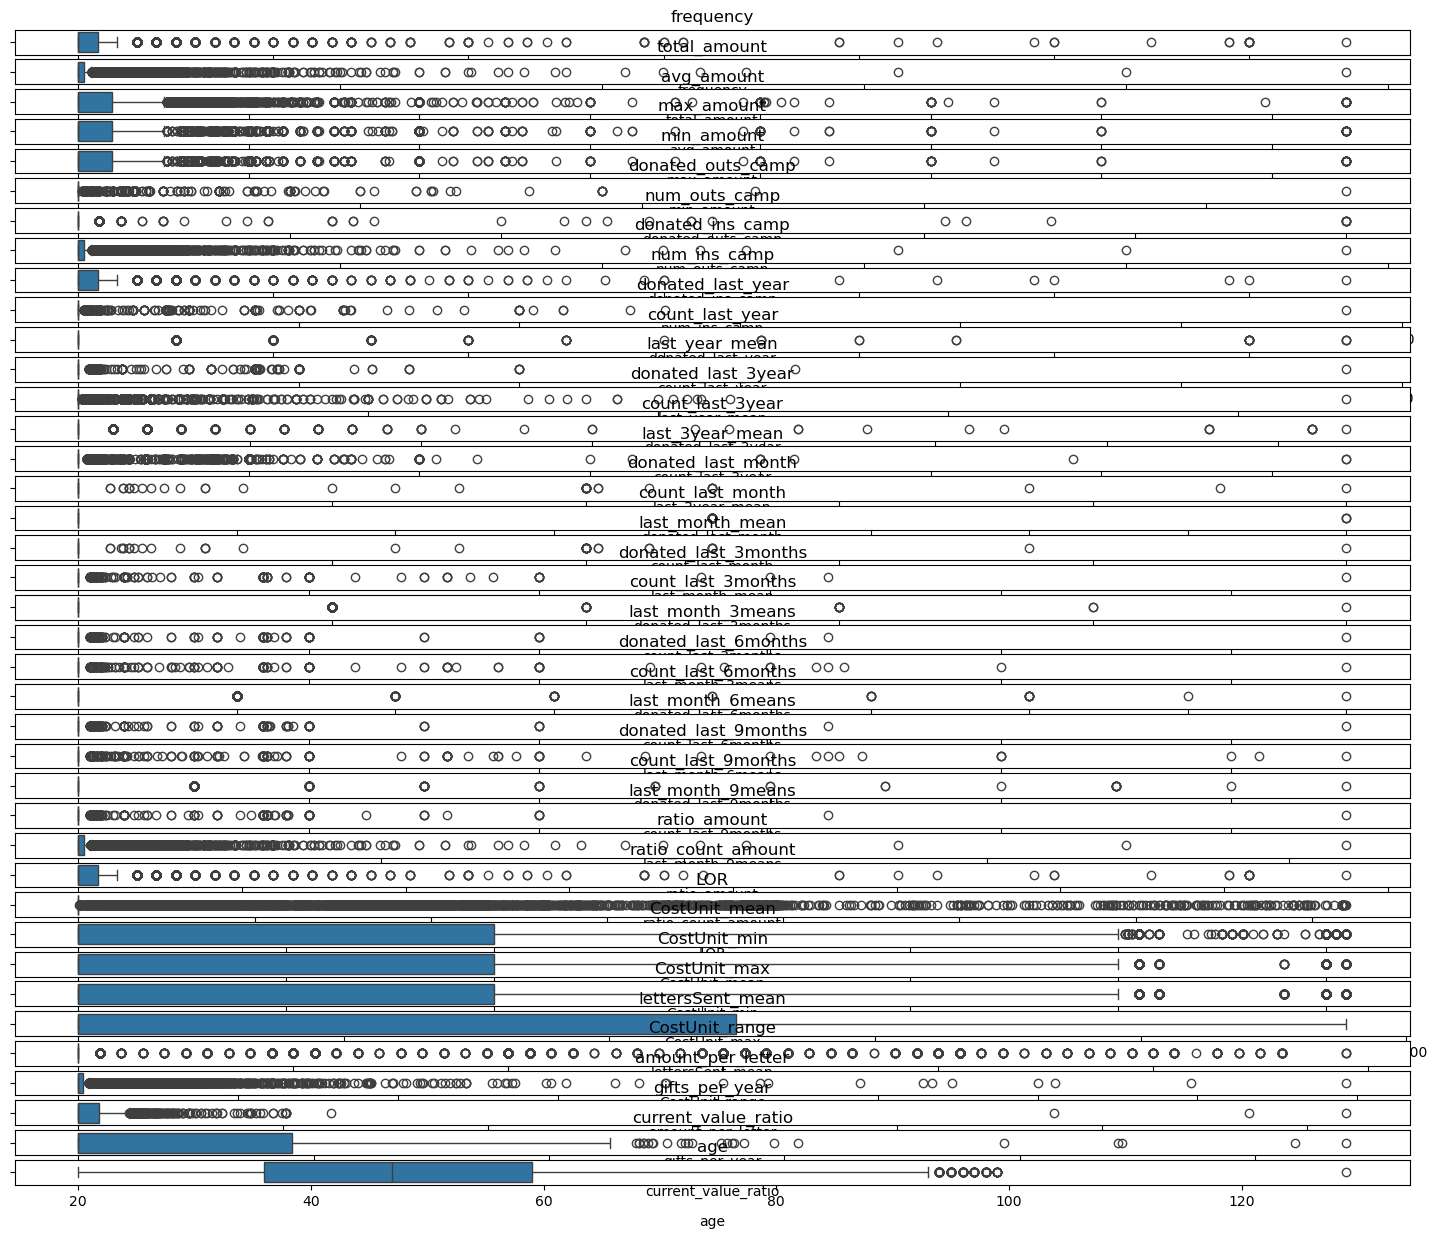

In [5718]:
# Verifying outliers

fig, ax = plt.subplots(nrows=len(na_cols_train), ncols=1, figsize=(18, 15))

for i, col in enumerate(na_cols_train):
    sns.boxplot(ax=ax[i], x=basetable_train[col])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [5719]:
# Removing the ages that are above 100
basetable_train = basetable_train[basetable_train['age'] < 100]
basetable_train['age'].max()

99

In [5720]:
# We decided to keep all the other variables with their 'outliers' because they represent a very large amount (find a justification)

## 2) basetable_val

### a) Cleaning columns

In [5721]:
basetable_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 64 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   donorID                   25645 non-null  object        
 1   dateOfBirth               25644 non-null  datetime64[ns]
 2   age                       25645 non-null  int64         
 3   province_Antwerp          25645 non-null  int64         
 4   province_Brussels         25645 non-null  int64         
 5   province_East Flanders    25645 non-null  int64         
 6   province_Flemish Brabant  25645 non-null  int64         
 7   province_Hainaut          25645 non-null  int64         
 8   province_Liege            25645 non-null  int64         
 9   province_Limburg          25645 non-null  int64         
 10  province_Luxembourg       25645 non-null  int64         
 11  province_Namur            25645 non-null  int64         
 12  province_Walloon B

In [5722]:
# Dropping
basetable_val = basetable_val.drop(columns=['dateOfBirth'])

In [5723]:
basetable_val.columns

Index(['donorID', 'age', 'province_Antwerp', 'province_Brussels',
       'province_East Flanders', 'province_Flemish Brabant',
       'province_Hainaut', 'province_Liege', 'province_Limburg',
       'province_Luxembourg', 'province_Namur', 'province_Walloon Brabant',
       'province_West Flanders', 'province_missing', 'region_Flanders',
       'region_Wallonia', 'region_missing', 'gender_M', 'language_FR',
       'language_NL', 'language_missing', 'age_group_middle_aged',
       'age_group_senior', 'age_group_youth', 'frequency', 'total_amount',
       'avg_amount', 'max_amount', 'min_amount', 'donated_outs_camp',
       'num_outs_camp', 'donated_ins_camp', 'num_ins_camp',
       'donated_last_year', 'count_last_year', 'last_year_mean',
       'donated_last_3year', 'count_last_3year', 'last_3year_mean',
       'donated_last_month', 'count_last_month', 'last_month_mean',
       'donated_last_3months', 'count_last_3months', 'last_month_3means',
       'donated_last_6months', 'count_last

In [5724]:
# Setting donorID to index
basetable_val = basetable_val.set_index('donorID') # Since we do not need it in the model but it still interesting to be reachable

### b) Missing values

In [5725]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(basetable_val.isna().sum())
print('---------------------------------')
print(f'The data shows {basetable_val.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
age                             0
province_Antwerp                0
province_Brussels               0
province_East Flanders          0
province_Flemish Brabant        0
                            ...  
lettersSent_mean            17384
CostUnit_range              17384
amount_per_letter           17384
gifts_per_year              16959
current_value_ratio         16959
Length: 62, dtype: int64
---------------------------------
The data shows 832595 missing values


In [5726]:
# Justify why we have that much missing values (business reality because some clients did not give within the 5 years window)

In [5727]:
na_cols_val = basetable_val.columns

for col in na_cols_val:
    if basetable_val[col].isna().sum() == 0:
        na_cols_val = na_cols_val.drop(col)
    else:
        continue

na_cols_val

Index(['frequency', 'total_amount', 'avg_amount', 'max_amount', 'min_amount',
       'donated_outs_camp', 'num_outs_camp', 'donated_ins_camp',
       'num_ins_camp', 'donated_last_year', 'count_last_year',
       'last_year_mean', 'donated_last_3year', 'count_last_3year',
       'last_3year_mean', 'donated_last_month', 'count_last_month',
       'last_month_mean', 'donated_last_3months', 'count_last_3months',
       'last_month_3means', 'donated_last_6months', 'count_last_6months',
       'last_month_6means', 'donated_last_9months', 'count_last_9months',
       'last_month_9means', 'ratio_amount', 'ratio_count_amount',
       'recency_days', 'LOR', 'CostUnit_mean', 'CostUnit_min', 'CostUnit_max',
       'lettersSent_mean', 'CostUnit_range', 'amount_per_letter',
       'gifts_per_year', 'current_value_ratio'],
      dtype='object')

In [5728]:
na_cols_val = na_cols_val.drop('recency_days') # recency should be inputed differently

In [5729]:
# Inputing by 0 for the others (they likely represent the same clients as well because they are the same number and ad interconnected)
for col in na_cols_val:
        basetable_val[col] = basetable_val[col].fillna(value=0)

In [5730]:
# We have to inpute recency with another value than 0 since 0 would mislead the model
# Indeed it would mean that as soon as the donnor received the mail, he would donate
basetable_val['recency_days'] = basetable_val['recency_days'].fillna(value=-1)

In [5731]:
print(f'There are {basetable_val.isna().sum().sum()} missing values in the basetable at this stage.')

There are 0 missing values in the basetable at this stage.


### c) Outliers

In [5732]:
# Finding outliers (using only the numerical columns)
na_cols_val = na_cols_val.tolist()
na_cols_val.append('age') # we can see that the potential outliers are in the numerical tables which also presented NaNs
# Therefore, we only add age to these to look for outliers because age is the only other one that could present some outliers as well
na_cols_val

['frequency',
 'total_amount',
 'avg_amount',
 'max_amount',
 'min_amount',
 'donated_outs_camp',
 'num_outs_camp',
 'donated_ins_camp',
 'num_ins_camp',
 'donated_last_year',
 'count_last_year',
 'last_year_mean',
 'donated_last_3year',
 'count_last_3year',
 'last_3year_mean',
 'donated_last_month',
 'count_last_month',
 'last_month_mean',
 'donated_last_3months',
 'count_last_3months',
 'last_month_3means',
 'donated_last_6months',
 'count_last_6months',
 'last_month_6means',
 'donated_last_9months',
 'count_last_9months',
 'last_month_9means',
 'ratio_amount',
 'ratio_count_amount',
 'LOR',
 'CostUnit_mean',
 'CostUnit_min',
 'CostUnit_max',
 'lettersSent_mean',
 'CostUnit_range',
 'amount_per_letter',
 'gifts_per_year',
 'current_value_ratio',
 'age']

C:\Users\Source\AppData\Local\Temp\ipykernel_38800\2490733849.py:9: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


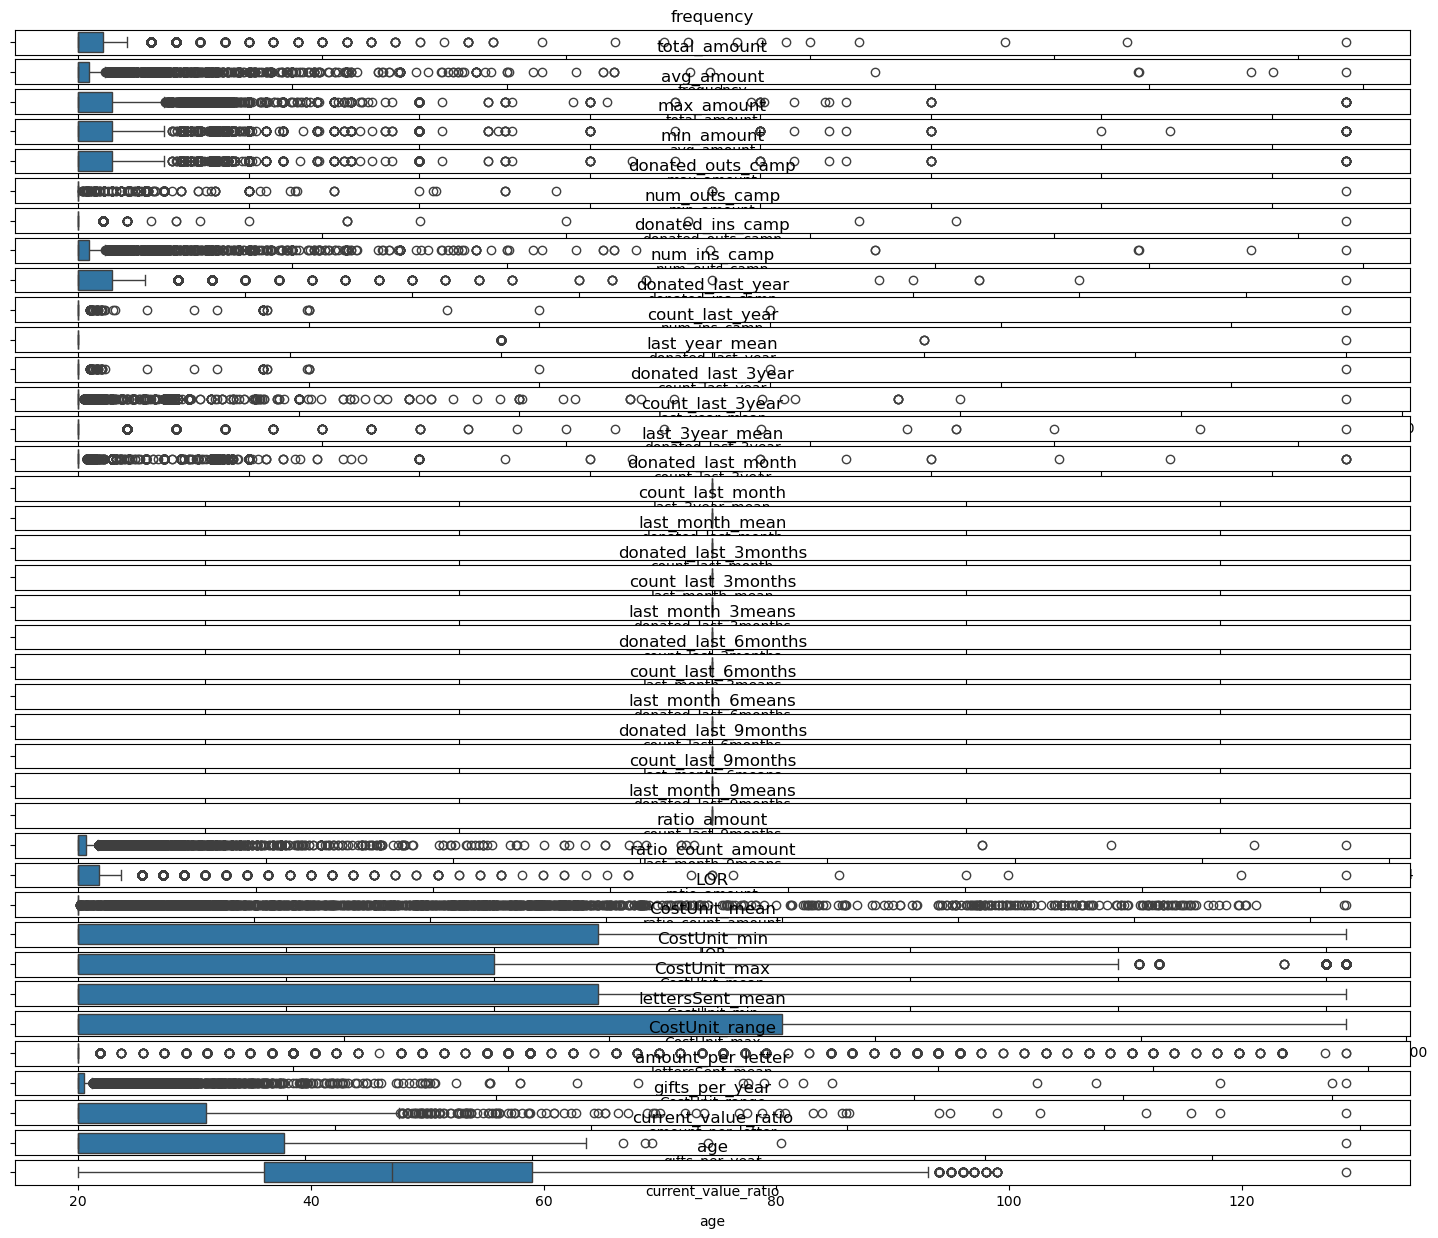

In [5733]:
# Verifying outliers

fig, ax = plt.subplots(nrows=len(na_cols_val), ncols=1, figsize=(18, 15))

for i, col in enumerate(na_cols_val):
    sns.boxplot(ax=ax[i], x=basetable_val[col])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [5734]:
# Removing the ages that are above 100
basetable_val = basetable_val[basetable_val['age'] < 100]
basetable_val['age'].max()

99

In [5735]:
# We decided to keep all the other variables with their 'outliers' because they represent a very large amount (find a justification)

In [5736]:
# Checking one last time the data

In [5737]:
train_targets.head()

,donorID,target
0,D100001,0
1,D100002,0
2,D100004,0
3,D100008,0
4,D100009,0


In [5738]:
validation_targets.head()

c:\Users\Source\.conda\envs\py\Lib\site-packages\IPython\core\displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,donorID,target
0,D100001,0
1,D100002,0
2,D100008,0
3,D100009,0
4,D100010,0


In [5739]:
basetable_train.head()

,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,province_Luxembourg,province_Namur,...,recency_days,LOR,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range,amount_per_letter,gifts_per_year,current_value_ratio
donorID,,,,,,,,,,,,,,,,,,,,,
D100001,51,0,0,0,1,0,0,0,0,0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
D100002,66,1,0,0,0,0,0,0,0,0,...,1333.0,0.0,0.5,0.5,0.5,37833.0,0.0,0.000529,1.0,0.952381
D100004,66,0,1,0,0,0,0,0,0,0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
D100008,81,0,0,0,1,0,0,0,0,0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
D100009,86,0,1,0,0,0,0,0,0,0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [5740]:
basetable_val.head()

,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,province_Luxembourg,province_Namur,...,recency_days,LOR,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range,amount_per_letter,gifts_per_year,current_value_ratio
donorID,,,,,,,,,,,,,,,,,,,,,
D100001,51,0,0,0,1,0,0,0,0,0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
D100002,66,1,0,0,0,0,0,0,0,0,...,1620.0,0.0,0.5,0.5,0.5,37833.0,0.0,0.000529,1.0,0.952381
D100008,81,0,0,0,1,0,0,0,0,0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
D100009,86,0,1,0,0,0,0,0,0,0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
D100010,35,0,1,0,0,0,0,0,0,0,...,1617.0,0.0,0.5,0.5,0.5,37833.0,0.0,0.001057,1.0,0.975610


In [5741]:
train_targets.shape

(34888, 2)

In [5742]:
basetable_train.shape

(34887, 62)

In [5743]:
validation_targets.shape

(25645, 2)

In [5744]:
basetable_val.shape

(25644, 62)

In [5745]:
# We notice that we have one row less in the basetable each time. This is due to the step when we filtered the basetable to remove the rows where
# the age was above 100 years old. We had only one (refer to the boxplot)
# Therefore, to adjust this situation, we have to merge the target variables into the basetable to be able to associate the right result with
# the right profile

In [5746]:
basetable_train = pd.merge(basetable_train, train_targets, left_index= True, right_on= 'donorID', how='left')
basetable_train.shape

(34887, 64)

In [5747]:
#sebastian
basetable_val = pd.merge(basetable_val, validation_targets, left_index= True, right_on= 'donorID', how='left')
basetable_val.shape

(25644, 64)

In [5748]:
basetable_train

,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,province_Luxembourg,province_Namur,...,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range,amount_per_letter,gifts_per_year,current_value_ratio,donorID,target
0,51,0,0,0,1,0,0,0,0,0,...,0.00,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,D100001,0
1,66,1,0,0,0,0,0,0,0,0,...,0.50,0.50,0.50,37833.0,0.0,0.000529,1.0,0.952381,D100002,0
2,66,0,1,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,D100004,0
3,81,0,0,0,1,0,0,0,0,0,...,0.00,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,D100008,0
4,86,0,1,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,D100009,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34883,54,1,0,0,0,0,0,0,0,0,...,0.32,0.32,0.32,18803.0,0.0,0.002659,1.0,0.980392,D144686,0
34884,48,0,0,0,0,0,1,0,0,0,...,0.20,0.20,0.20,24753.0,0.0,0.000404,1.0,0.909091,D144687,0
34885,51,0,0,0,1,0,0,0,0,0,...,0.30,0.30,0.30,39445.0,0.0,0.002535,1.0,0.990099,D144689,0
34886,42,0,0,0,1,0,0,0,0,0,...,0.50,0.50,0.50,37833.0,0.0,0.001057,1.0,0.975610,D144690,0


## Univariate analysis

In [ ]:
training_x = basetable_train.loc[:, basetable_train.columns[:-2]].copy()
training_x.insert(0, "donorID", basetable_train.index)

training_y = basetable_train['target']

training_x = basetable_val.loc[:, basetable_val.columns[:-2]].copy()
training_x.insert(0, "donorID", basetable_val.index)

validation_y = basetable_val['target']


In [5556]:
training_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34887 entries, 0 to 34887
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       34887 non-null  int64  
 1   province_Antwerp          34887 non-null  int64  
 2   province_Brussels         34887 non-null  int64  
 3   province_East Flanders    34887 non-null  int64  
 4   province_Flemish Brabant  34887 non-null  int64  
 5   province_Hainaut          34887 non-null  int64  
 6   province_Liege            34887 non-null  int64  
 7   province_Limburg          34887 non-null  int64  
 8   province_Luxembourg       34887 non-null  int64  
 9   province_Namur            34887 non-null  int64  
 10  province_Walloon Brabant  34887 non-null  int64  
 11  province_West Flanders    34887 non-null  int64  
 12  province_missing          34887 non-null  int64  
 13  region_Flanders           34887 non-null  int64  
 14  region_Wall

In [5557]:
validation_y.info()

<class 'pandas.core.series.Series'>
Index: 25644 entries, 0 to 25644
Series name: target
Non-Null Count  Dtype
--------------  -----
25644 non-null  int64
dtypes: int64(1)
memory usage: 400.7 KB


Scaled

In [5558]:
training_x.iloc[:,23:].shape

(34887, 39)

In [5559]:
validation_x.iloc[:,23:].shape

(25644, 39)

In [5560]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
#Columns to be scaled 

cols_to_scale = list(validation_x.columns[1:29])

X_train_scaled   = training_x.copy()
X_validation_scaled = validation_x.copy()

scaler = StandardScaler()
X_train_scaled[cols_to_scale] = scaler.fit_transform(training_x[cols_to_scale])
X_validation_scaled[cols_to_scale] = scaler.transform(validation_x[cols_to_scale])


In [5561]:
max_features = training_x.shape[1]  # Number of features
train_auc_scores = []
validation_auc_scores = []

for k in range(1, max_features + 1):
    # Perform univariate feature selection with SelectKBest
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_kbest = selector.fit_transform(X_train_scaled, training_y)
    X_validation_kbest = selector.transform(X_validation_scaled)

    # Step 4: Build logistic regression model with class_weight='balanced'
    model = LogisticRegression(class_weight='balanced', random_state=10)
    model.fit(X_train_kbest,training_y)

    # Step 5: Predict probabilities on train and validation set
    y_train_prob = model.predict_proba(X_train_kbest,)[:, 1]
    y_validation_prob = model.predict_proba(X_validation_kbest)[:, 1]

    # Calculate AUC score for both train and validation set
    train_auc = roc_auc_score(training_y, y_train_prob)
    validation_auc = roc_auc_score(validation_y, y_validation_prob)
   

    # Append AUC scores
    train_auc_scores.append(train_auc)
    validation_auc_scores.append(validation_auc)

c:\Users\Source\.conda\envs\py\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Source\.conda\envs\py\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pl

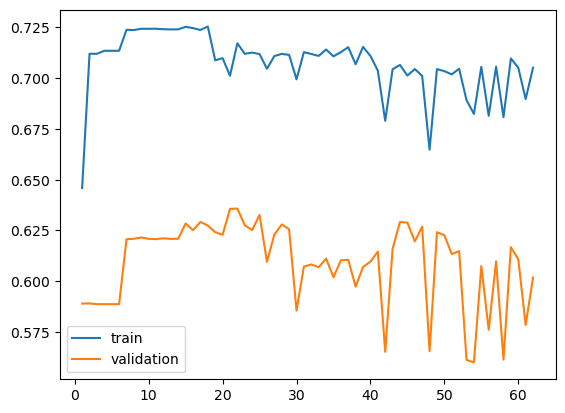

In [5562]:
# Step 6: Plot the AUC scores
k_values = range(1, max_features + 1)
plt.plot(k_values, train_auc_scores, label = 'train')
plt.plot(k_values, validation_auc_scores, label = 'validation')
plt.legend()

In [5563]:
best_k = np.argmax(validation_auc_scores) + 1
print(best_k)

22


In [5564]:
selector = SelectKBest(score_func=f_classif, k=best_k)
selector.fit(X_train_scaled, training_y)

# Get the boolean mask of selected features for k=?
selected_features = training_x.columns[selector.get_support()]

# Get the feature importance scores for k=?
feature_scores = selector.scores_

# Combine feature names and their scores into a DataFrame for easier visualization
feature_importance = pd.DataFrame({
    'Feature': training_x.columns,
    'Score': feature_scores
})

# Sort the features by their score in descending order
feature_importance.sort_values('Score', ascending=False).head(20)

,Feature,Score
16,gender_M,265.839469
0,age,223.769915
21,age_group_senior,183.681710
19,language_missing,93.285069
15,region_missing,93.285069
12,province_missing,93.285069
26,max_amount,56.079878
25,avg_amount,55.401923
27,min_amount,52.124489
32,donated_last_year,40.351377


In [5565]:
model = LogisticRegression(solver = "lbfgs", max_iter = 800, class_weight = 'balanced')


In [5566]:
from sklearn.feature_selection import SequentialFeatureSelector
selected = list(feature_importance.sort_values('Score', ascending=False).iloc[:best_k]['Feature'])
X_train_scaled = X_train_scaled[selected]
X_validation_scaled = X_validation_scaled[selected]

sfs = SequentialFeatureSelector(
    estimator=model,
    n_features_to_select='auto',   # o un número fijo si quieres, ej. 15
    direction='forward',
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

sfs.fit(X_train_scaled, training_y)
selected_features = X_train_scaled.columns[sfs.get_support()].tolist()
print(f"Selected Features: {selected_features}")

Selected Features: ['gender_M', 'age', 'age_group_senior', 'language_missing', 'region_missing', 'province_missing', 'max_amount', 'avg_amount', 'donated_last_year', 'ratio_amount', 'donated_last_6months']


In [5567]:
model.fit(X_train_scaled[selected_features], training_y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,800
,multi_class,'deprecated'


In [5568]:
training_x["predicted_don"] = model.predict(X_train_scaled[selected_features])
validation_x["predicted_don"] = model.predict(X_validation_scaled[selected_features])

In [5569]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(accuracy_score(training_y ,training_x['predicted_don'])*100)    
print(accuracy_score(validation_y,validation_x['predicted_don'])*100)

65.35385673746667
65.27842770238652


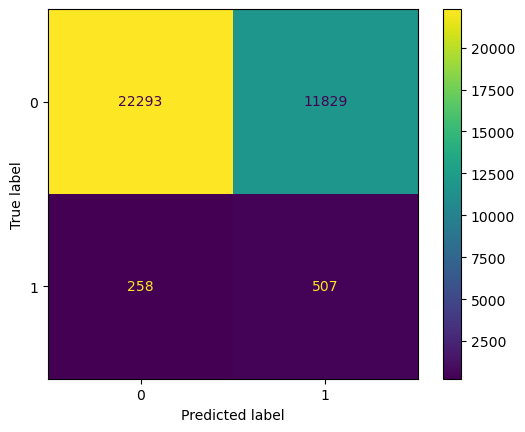

In [5570]:
#plot a confusion matrix from the test set
from matplotlib import pyplot
cm = confusion_matrix(training_y, training_x['predicted_don'], labels=model.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
pyplot.show()

In [5571]:
training_x["proba_don"] = model.predict_proba(X_train_scaled[selected_features])[:,1]
validation_x["proba_don"] = model.predict_proba(X_validation_scaled[selected_features])[:, 1]

In [5572]:
training_x

,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,province_Luxembourg,province_Namur,...,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range,amount_per_letter,gifts_per_year,current_value_ratio,predicted_don,proba_don
0,51,0,0,0,1,0,0,0,0,0,...,0.00,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,1,0.570920
1,66,1,0,0,0,0,0,0,0,0,...,0.50,0.50,0.50,37833.0,0.0,0.000529,1.0,0.952381,0,0.482087
2,66,0,1,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,1,0.698484
3,81,0,0,0,1,0,0,0,0,0,...,0.00,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,1,0.509806
4,86,0,1,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,1,0.541540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34883,54,1,0,0,0,0,0,0,0,0,...,0.32,0.32,0.32,18803.0,0.0,0.002659,1.0,0.980392,1,0.738767
34884,48,0,0,0,0,0,1,0,0,0,...,0.20,0.20,0.20,24753.0,0.0,0.000404,1.0,0.909091,0,0.301942
34885,51,0,0,0,1,0,0,0,0,0,...,0.30,0.30,0.30,39445.0,0.0,0.002535,1.0,0.990099,1,0.615803
34886,42,0,0,0,1,0,0,0,0,0,...,0.50,0.50,0.50,37833.0,0.0,0.001057,1.0,0.975610,0,0.357944


In [5573]:
training_x[["predicted_don","proba_don"]]

,predicted_don,proba_don
0,1,0.570920
1,0,0.482087
2,1,0.698484
3,1,0.509806
4,1,0.541540
...,...,...
34883,1,0.738767
34884,0,0.301942
34885,1,0.615803
34886,0,0.357944


In [5574]:
aucTraining = roc_auc_score(np.array(training_y), np.array(training_x['proba_don']))
aucTest     = roc_auc_score(np.array(validation_y), np.array(validation_x['proba_don']))

print(f"auc training set : {aucTraining}")
print(f"auc test set     : {aucTest}")

auc training set : 0.7247136859550103
auc test set     : 0.6211037876863038


In [5575]:
coefficients = model.coef_[0]  # Extract coefficients
variable_importance = pd.DataFrame({'Feature': X_train_scaled[selected_features].columns, 'Coefficient': coefficients, 'abs_value_coeff': abs(coefficients)})
variable_importance = variable_importance.sort_values(by='abs_value_coeff', ascending=False)
variable_importance

,Feature,Coefficient,abs_value_coeff
0,gender_M,-0.581176,0.581176
7,avg_amount,0.348057,0.348057
6,max_amount,-0.105092,0.105092
2,age_group_senior,0.065372,0.065372
1,age,0.025463,0.025463
4,region_missing,0.022119,0.022119
3,language_missing,0.022119,0.022119
5,province_missing,0.022119,0.022119
8,donated_last_year,0.022086,0.022086
10,donated_last_6months,-0.021948,0.021948
